In [38]:
import pandas as pd
import os
from scipy.stats import skew, kurtosis
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from optimizers.simulations.order import simulate_lqe_model
from optimizers.utils._utils import get_csv_data
from optimizers.cross_validators import vbt_cv_sliding_constructor
from research.pipes.sql import SQLPipe
from research.utils import kalmanfilter

load_dotenv()

USER = os.getenv('psql_username')
PASS = os.getenv('psql_password')
DATABASE = 'crypto'
SCHEMA = 'bihourly'

pipe = SQLPipe(SCHEMA, DATABASE, USER, PASS, interval='30T')

In [39]:
assets = ['AXS-USDT', 'VRA-USDT']
slicer = -25000 # Slice off first few months of trading to reduce early volatility

df = pipe.query_pairs_trading_backtest(assets)
closes = df.xs('close', level=1, axis=1)[slicer:]
opens = df.xs('open', level=1, axis=1)[slicer:]
assert closes.shape[0] > 8640, 'Less than 1 year of backtesting data present'
assert closes.shape == opens.shape, 'Open and close shape does not match'

print(f"Full data length: {closes.shape[0]}")

n = 3
train_opens, opens = train_test_split(opens, test_size=0.30, train_size=0.70, shuffle=False)
train_closes, closes = train_test_split(closes, test_size=0.30, train_size=0.70, shuffle=False)
close_folds = vbt_cv_sliding_constructor(train_closes, n_splits=n)
open_folds = vbt_cv_sliding_constructor(train_opens, n_splits=n)

print(f"Test data length: {opens.shape[0]}")
print(f"Train fold length {close_folds[0].shape[0]}")

Full data length: 21196
Test data length: 6359
Train fold length 4945


In [40]:
# EOS FIL works on a CUMMLOG model but has volatility in per trade returns
# FIL THETA & LINK CHZ, BTC ZEC. BTCZEC might work, but had generalization issues
# ADA ZEC is untestable due to massive regime shift mid test set for LOG model
# Something is bizarre and wrong with the ADA ZEC data; needs review?
# BSV 1INCH 70 2.1 -2.4 1.3 5.000000e-07 0.00030 CUMMLOG <- does not work past 10bps slippage
# XLM1INCH, LTCCHZ, DGBCAKE, NEODGB, DGBDASH, GRT1INCH failed backtesting
# THETA FIL 100 1.2 -1.2 0.3 9.e-8 4.e-5 LOG seems to work
# BATANKR 303 0.7 -2.7 0.4 3.e-9 1.7e-5 LOG
# LTCCHZ works, but apparently failed to hedge (same issue as with CHZWIN) <- this might be fixed now
# BNBTRX (LOG) failed
# BNBTRX CUMMLOG 615 1.9 -2.2 1.4 8e-6 0.3 <- low sharpe, but high WR. High duration. Deploy with minor alloc?
# XLM SUN / SUN XLM  does not generalize well. Low trade count, high duration
# XMR ETH failed across all models. Still need to test ETH XMR
# ASX VRA DEFAULT 20 2.0 -1.8 0.6 8e-8 1.2 <- extremely successful 1hour
# DOGE SUN / SUN DOGEfailed on all models
# FIL CAKE DEFAULT 510 1.6 -1.4 0.1 6e-6 7e-1 returned low trade count, high duration, but ~2 sharpe, high wr, high pr. Bears live testing
# THETA FIL LOG 355 1.5 -1.5 1.2 1E-9 0.15 works quite well at 20bps slippage. Fat tail risk in trades leads to low sharpe
# EOS CAKE does not work on any metric; XMR CAKE LOG failed
# SHIB DOGE / DOGE SHIB 30MIN LOG RET & LOG model failed to generalize
# THETA FIL LOG BETA 845 0.9 -1.6 0.8 8e-9 1.6 30MIN <- high sharpe / 410 0.6 -2.7 0.2 6e-9 1.8 30MIN <- lower sharpe
# AXS VRA 920 2.7 -2.4 0.8 1e-9 1.3-8 LOG 30M BETA <- high freq ~2x sharpe DEPLOY TO LIVE TEST // Results in NEGATIVE beta...

PERIOD = 920
UPPER = 2.7
LOWER = -2.4
EXIT = 0.8
DELTA = 1e-9
VT = 1.3e-8
BURNIN = 600
MODEL = 'log'
HEDGE = 'beta'
SLIPPAGE = 0.0010
FREQ = '30T'

In [41]:
pf = simulate_lqe_model(
    closes, opens,
    period=PERIOD,
    upper=UPPER,
    lower=LOWER,
    exit=EXIT,
    delta=DELTA,
    vt=VT,
    burnin=BURNIN,
    freq=FREQ,
    hedge=HEDGE,
    transformation=MODEL,
    slippage=SLIPPAGE,
    order_size=0.10,
)

-1.0333488180522516
-1.037938143064035
-1.0664723633710467
-1.0489133190996582
-1.013911362240788
-1.0326376498310215
-1.0236744774872286
-0.9954747966393347
-0.9064750381111361
-0.899001095790666
-0.7675315028824323
-0.7024038620728269
-0.7077506032157642
-0.6514747701856504
-0.5923475365524944
-0.5090133603546192
-0.14378711956918996
-0.14274397912179643
-0.15698838625763412
-0.14674131177435204
-0.12590630949857115
-0.0999525692659324
-0.060080691089407605
-0.003681257191771911
0.03730558062042992
0.047316268314452875
0.0774013238984429
0.1079875004260714
0.0929674650857192
0.10624421677700559
0.10149294104973514
0.10205143099172942
0.1467750409765169
0.19343128349534677
0.1704268351754647
0.17449253435230305
0.18967986619882687
0.23311861738989517
0.24953896849192803
0.30574133951380034
0.3471235226241674
0.35426202720260547
0.37091390329830976
0.3581205320732012
0.3833838862412502
0.3997368158641711
0.38607350453756206
0.3911142557773961
0.37572040770419296
0.38055769890459784
0.3

0.03298703687008714


<AxesSubplot:>

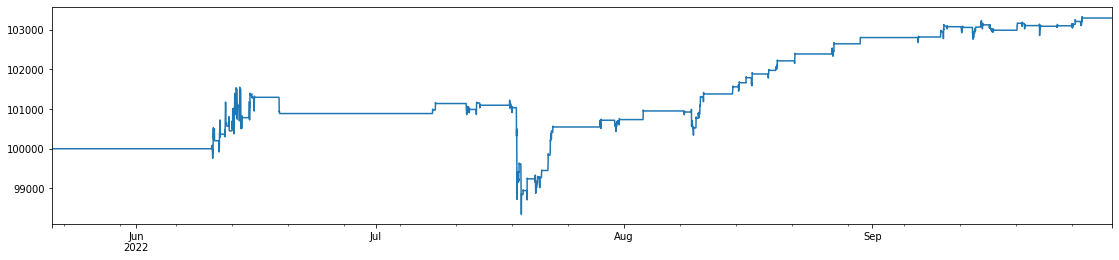

In [42]:
print(pf.total_return())
pf.value().plot(figsize=(19,4))

In [43]:
pnl = (pf.trades.records_readable.groupby('Entry Timestamp').sum().PnL.resample('D').sum())
val = pf.value().resample('D').asfreq().fillna(pf.value())
res = pd.concat([pnl, val], axis=1, keys=['pnl', 'val'])
res = res.fillna(0)
res['ret'] = res.pnl / res.val
Rf = (1 + 0) ** (1/365) - 1 # Daily risk free rate
Rp = res.ret.mean() # Daily portfolio return
STDp = res.ret.std() # Daily standard deviation of return
sharpe = ((Rp - 0) / STDp) * np.sqrt(365) # Annualized sharpe

In [44]:
res = pf.trades.records_readable.groupby("Entry Timestamp").sum()

print(f"Total trades: {res.shape[0]}")
print(f"Executed trades: {pf.trades.records_readable.shape[0]}")
print(f"Profit Ratio: {res.PnL[res.PnL > 0].mean() / np.abs(res.PnL[res.PnL < 0].mean()):.3f}")
print(f"Net long-short win rate: {res.PnL[res.PnL > 0].shape[0] / res.shape[0] * 100:.2f}%")
print(f"Median trade profit: {res.PnL.median():.2f}")
print(f"Mean trade profit: {res.PnL.mean():.2f}")
print(f"STD of trade profit: {res.PnL.std():.2f}")
print(f"Sharpe ratio: {sharpe:.4f}")

Total trades: 74
Executed trades: 148
Profit Ratio: 0.810
Net long-short win rate: 66.22%
Median trade profit: 90.98
Mean trade profit: 44.58
STD of trade profit: 304.70
Sharpe ratio: 2.1586


<AxesSubplot:xlabel='Entry Timestamp'>

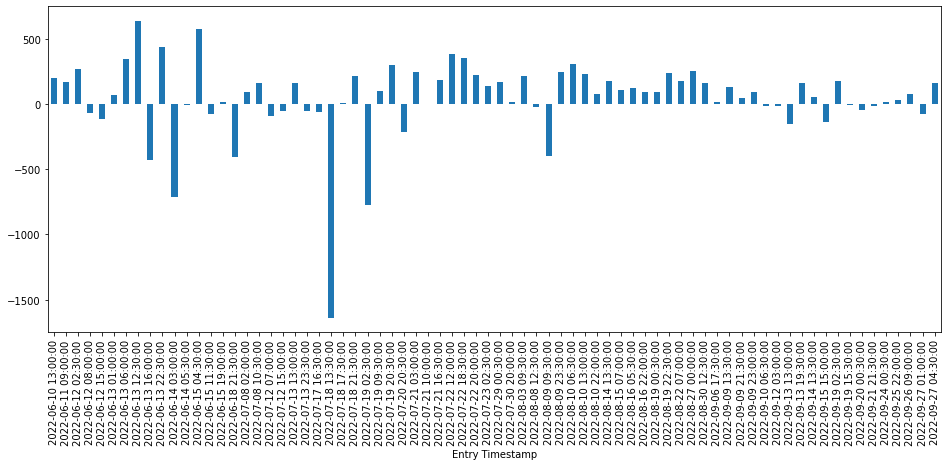

In [45]:
res.PnL.plot(kind="bar", figsize=(16,6))

Kurtosis: 14.801613197855298
Skew: -2.6490079174650063


<AxesSubplot:ylabel='Frequency'>

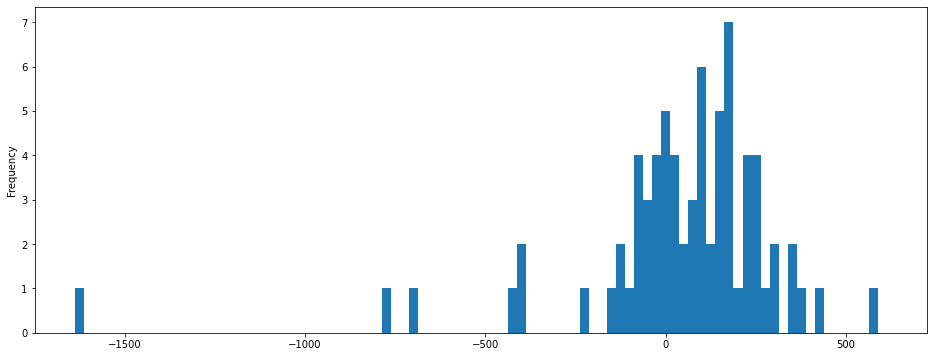

In [46]:
print(f'Kurtosis: {kurtosis(res.PnL, fisher=False)}')
print(f'Skew: {skew(res.PnL)}')

bins = np.arange(res.PnL.min(), res.PnL.max(), 25)
res.PnL.plot(kind="hist", figsize=(16,6), bins=bins)

In [47]:
if MODEL == 'log':
    data = np.log(closes)
elif MODEL == 'logret':
    data = np.log1p(closes.pct_change()).dropna()
res = kalmanfilter(data, DELTA, VT, export_df=True)

trade_df = pf.trades.records_readable.sort_values('Entry Timestamp')
g = trade_df.groupby('Entry Timestamp')
x, y = assets
betas = []

for idx, gr in g:
    if gr.Direction.nunique() == 1:
        sign = -1
    else:
        sign = 1
    xv = gr[gr['Column'] == x]
    yv = gr[gr['Column'] == y]
    xval = xv['Size'] * xv['Avg Entry Price']
    yval = yv['Size'] * yv['Avg Entry Price']
    beta = (xval.values / yval.values) * sign
    betas.append(beta)

betas = np.vstack(betas).flatten()
ser = pd.Series(betas, index=trade_df['Entry Timestamp'].unique(), name='beta')

print(np.sign(ser).value_counts())

 1.0    50
-1.0    24
Name: beta, dtype: int64


In [48]:
# from kucoincli.client import Client

# client = Client()

# df = client.ohlcv(['AXS-USDT', 'VRA-USDT'], start='2017-07-01', interval='30min', warning=False)
# data = df.xs('close', level=1, axis=1).dropna()

In [49]:
d = pd.read_csv('test.csv', index_col=0)

res = kalmanfilter(d, DELTA, VT, export_df=True)

<AxesSubplot:xlabel='time'>

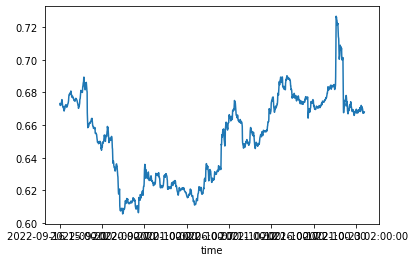

In [50]:
res.slope[-1800:].plot()